<a href="https://colab.research.google.com/github/rnarkk/PPBMH/blob/main/Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Programming and Bayesian Methods for Hackers Chapter  5

<table class = "tfo-notebook-buttons" align = "left">
  <td>
    <a target = "_blank" href = "https://colab.research.google.com/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_TFP.ipynb"><img height = "32px" src = "https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target = "_blank" href = "https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_TFP.ipynb"><img src = "https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content ([this Jupyter notebook](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC2.ipynb#Example:-Kaggle-contest-on-Observing-Dark-World)) created by Cam Davidson-Pilon ([`@Cmrn_DP`](https://twitter.com/Cmrn_DP)) and Tim Salimans ([`@TimSalimans`](https://twitter.com/TimSalimans))

Welcome to Bayesian Methods for Hackers. The full Github repository is available at [github/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers). The other chapters can be found on the project's [homepage](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/). We hope you enjoy the book, and we encourage any contributions!

### Table of Contents

- Would you rather lose and arm or a leg?
- Loss Functions
- Loss functions in the real world
- Example: optimising for the Showcase on The Price is Right
  - Minimising our losses
  - Shortcuts
  - Machine Learning via Bayesian Methods
- Example: Financial prediction
- Example: Kaggle contest on Observing Dark World
  - Setup
  - Defining our galaxy-plotting function
  - Examining Our Data
  - Priors
  - Training & Tensorflow implemenation
    - Constructing a probabilistic model for the data (observed ellipcities o the galaxies) given the positions of the dark matter halos
    - Using Bayes' rule to get the posterior distribution of the halo positions, i.e. to use the data to guess wherre the dark matter halos might be
  - References

## Loss Functions

In [24]:
!pip3 install -Uq pip
!pip3 uninstall -yq tensorflow tensorflow-probability
!pip3 install -Uq jax oryx tfp-nightly[jax]

!pip3 install -q praw wget

In [25]:
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)
"""
from jax import random
from jax.numpy import *
from jax.numpy import int32 as i32, float32 as f32
from jax.lax import atan
from jax.scipy.optimize import minimize
from oryx import bijectors as tfb
from oryx.distributions import (
    Binomial, Exponential, Independent, Normal, Poisson, Uniform)
from tensorflow_probability.substrates import jax as tfp

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import wget

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'

%matplotlib inline

sns.set_context('notebook')

TFColor = [
    '#F15854',
    '#5DA5DA',
    '#FAA43A',
    '#60BD68',
    '#F17CB0',
    '#B2912F',
    '#B276B2',
    '#DECF3F',
    '#4D4D4D']

### Would you rather lose an arm or a leg?

Statisticians can be a sour bunch. Instead of considering their winnings, they only measure how much they have lost. In fact, they consider their wins as *negative losses*. But what's interesting is *how they measure their losses.*

For example, consider the following example:

>   A meteorologist is predicting the probability of a possible hurricane striking his city. He estimates, with 95% confidence, that the probability of it *not* striking is between 99% - 100%. He is very happy with his precision and advises the city that a major evacuation is unnecessary. Unfortunately, the hurricane does strike and the city is flooded. 

This stylised example shows the flaw in using a pure accuracy metric to measure outcomes. Using a measure that emphasises estimation accuracy, while an appealing and *objective* thing to do, misses the point of why you are even performing the statistical inference in the first place: results of inference. The author Nassim Taleb of *The Black Swan* and *Antifragility* stresses the importance of the *payoffs* of decisions, *not the accuracy*. Taleb distills this quite succinctly: "I would rather be vaguely right than very wrong."  

## Loss Functions

We introduce what statisticians and decision theorists call *loss functions*. A loss function is a function of the true parameter, and an estimate of that parameter

$$ L( \theta, \hat{\theta} ) = f( \theta, \hat{\theta} )$$

The important point of loss functions is that it measures how *bad* our current estimate is: the larger the loss, the worse the estimate is according to the loss function. A simple, and very common, example of a loss function is the *squared-error loss*:

$$ L( \theta, \hat{\theta} ) = ( \theta -  \hat{\theta} )^2$$

The squared-error loss function is used in estimators like linear regression, UMVUEs and many areas of machine learning. We can also consider an asymmetric squared-error loss function, something like:

$$ L( \theta, \hat{\theta} ) = \begin{cases} ( \theta -  \hat{\theta} )^2 & \hat{\theta} \lt \theta \\\\ c( \theta -  \hat{\theta} )^2 & \hat{\theta} \ge \theta, \;\; 0\lt c \lt 1 \end{cases}$$


which represents that estimating a value larger than the true estimate is preferable to estimating a value below. A situation where this might be useful is in estimating web traffic for the next month, where an over-estimated outlook is preferred so as to avoid an underallocation of server resources. 

A negative property about the squared-error loss is that it puts a disproportionate emphasis on large outliers. This is because the loss increases quadratically, and not linearly, as the estimate moves away. That is, the penalty of being three units away is much less than being five units away, but the penalty is not much greater than being one unit away, though in both cases the magnitude of difference is the same:

$$ \frac{1^2}{3^2} \lt \frac{3^2}{5^2}, \;\; \text{although} \;\; 3-1 = 5-3 $$

This loss function imposes that large errors are *very* bad. A more *robust* loss function that increases linearly with the difference is the *absolute-loss*

$$ L( \theta, \hat{\theta} ) = | \theta -  \hat{\theta} | $$

Other popular loss functions include:

-  $L( \theta, \hat{\theta} ) = \mathbb{1}_{ \hat{\theta} \neq \theta }$ is the zero-one loss often used in machine learning classification algorithms.
-  $L( \theta, \hat{\theta} ) = -\theta\log( \hat{\theta} ) - (1- \theta)\log( 1 - \hat{\theta} ), \; \; \theta \in {0,1}, \; \hat{\theta} \in [0,1]$, called the *log-loss*, also used in machine learning. 

Historically, loss functions have been motivated from 1) mathematical convenience, and 2) they are robust to application, i.e., they are objective measures of loss. The first reason has really held back the full breadth of loss functions. With computers being agnostic to mathematical convenience, we are free to design our own loss functions, which we take full advantage of later in this Chapter.

With respect to the second point, the above loss functions are indeed objective, in that they are most often a function of the difference between estimate and true parameter, independent of signage or payoff of choosing that estimate. This last point, its independence of payoff, causes quite pathological results though. Consider our hurricane example above: the statistician equivalently predicted that the probability of the hurricane striking was between 0% to 1%. But if he had ignored being precise and instead focused on outcomes (99% chance of no flood, 1% chance of flood), he might have advised differently. 

By shifting our focus from trying to be incredibly precise about parameter estimation to focusing on the outcomes of our parameter estimation, we can customise our estimates to be optimised for our application. This requires us to design new loss functions that reflect our goals and outcomes. Some examples of more interesting loss functions:


- $L( \theta, \hat{\theta} ) = \frac{ | \theta - \hat{\theta} | }{ \theta(1-\theta) }, \; \; \hat{\theta}, \theta \in [0,1]$ emphasises an estimate closer to 0 or 1 since if the true value $\theta$ is near 0 or 1, the loss will be *very* large unless $\hat{\theta}$ is similarly close to 0 or 1. 
This loss function might be used by a political pundit whose job requires him or her to give confident "Yes/No" answers. This loss reflects that if the true parameter is close to 1 (for example, if a political outcome is very likely to occur), he or she would want to strongly agree as not to look like a sceptic. 

-  $L( \theta, \hat{\theta} ) =  1 - \exp \left( -(\theta -  \hat{\theta} )^2 \right)$ is bounded between 0 and 1 and reflects that the user is indifferent to sufficiently-far-away estimates. It is similar to the zero-one loss above, but not quite as penalising to estimates that are close to the true parameter. 
-  Complicated non-linear loss functions can be programmed: 
```python
        def loss(true_value, estimate):
            if estimate * true_value > 0:
                return abs(estimate - true_value)
            else:
               return abs(estimate) * (estimate - true_value)**2
```


-  Another example is from the book *The Signal and The Noise*. Weather forecasters have an interesting loss function for their predictions.


>  People notice one type of mistake &mdash; the failure to predict rain &mdash; more than other, false alarms. If it rains when it isn't supposed to, they curse the weatherman for ruining their picnic, whereas an unexpectedly sunny day is taken as a serendipitous bonus.

>  [The Weather Channel's bias] is limited to slightly exaggerating the probability of rain when it is unlikely to occur &mdash; saying there is a 20 percent change when they know it is really a 5 or 10 percent chance &mdash; covering their butts in the case of an unexpected sprinkle.


As you can see, loss functions can be used for good and evil: with great power, comes great &mdash; well you know.


##  Loss functions in the real world

So far we have been under the unrealistic assumption that we know the true parameter. Of course if we knew the true parameter, bothering to guess an estimate is pointless. Hence a loss function is really only practical when the true parameter is unknown. 

In Bayesian inference, we have a mindset that the unknown parameters are really random variables with prior and posterior distributions. Concerning the posterior distribution, a value drawn from it is a *possible* realisation of what the true parameter could be. Given that realisation, we can compute a loss associated with an estimate. As we have a whole distribution of what the unknown parameter could be (the posterior), we should be more interested in computing the *expected loss* given an estimate. This expected loss is a better estimate of the true loss than comparing the given loss from only a single sample from the posterior.

First it will be useful to explain a *Bayesian point estimate*. The systems and machinery present in the modern world are not built to accept posterior distributions as input. It is also rude to hand someone over a distribution when all they asked for was an estimate. In the course of an individual's day, when faced with uncertainty we still act by distilling our uncertainty down to a single action. Similarly, we need to distill our posterior distribution down to a single value (or vector in the multivariate case). If the value is chosen intelligently, we can avoid the flaw of frequentist methodologies that mask the uncertainty and provide a more informative result. The value chosen, if from a Bayesian posterior, is a Bayesian point estimate. 

Suppose $P(\theta | X)$ is the posterior distribution of $\theta$ after observing data $X$, then the following function is understandable as the *expected loss of choosing estimate $\hat{\theta}$ to estimate $\theta$*:

$$ l(\hat{\theta} ) = E_{\theta}\left[L(\theta, \hat{\theta}) \right] $$

This is also known as the *risk* of estimate $\hat{\theta}$. The subscript $\theta$ under the expectation symbol is used to denote that $\theta$ is the unknown (random) variable in the expectation, something that at first can be difficult to consider.

We spent all of last chapter discussing how to approximate expected values. Given $N$ samples $\theta_i,\; i = 1,...,N$ from the posterior distribution, and a loss function $L$, we can approximate the expected loss of using estimate $\hat{\theta}$ by the Law of Large Numbers:

$$\frac{1}{N} \sum_{i = 1}^N L(\theta_i, \hat{\theta} ) \approx E_{\theta}\left[L(\theta, \hat{\theta}) \right]  = l(\hat{\theta}) $$

Notice that measuring your loss via an *expected value* uses more information from the distribution than the MAP estimate which, if you recall, will only find the maximum value of the distribution and ignore the shape of the distribution. Ignoring information can over-expose yourself to tail risks, like the unlikely hurricane, and leaves your estimate ignorant of how ignorant you really are about the parameter.

Similarly, compare this with frequentist methods, that traditionally only aim to minimise the error, and do not consider the *loss associated with the result of that error*. Compound this with the fact that frequentist methods are almost guaranteed to never be absolutely accurate. Bayesian point estimates fix this by planning ahead: your estimate is going to be wrong, you might as well err on the right side of wrong.

## Example: Optimising for the *Showcase* on *The Price is Right*

Bless you if you are ever chosen as a contestant on the Price is Right, for here we will show you how to optimise your final price on the *Showcase*. For those who forget the rules:


1. Two contestants compete in *The Showcase*. 
2. Each contestant is shown a unique suite of prizes.
3. After the viewing, the contestants are asked to bid on the price for their unique suite of prizes.
4. If a bid price is over the actual price, the bid's owner is disqualified from winning.
5. If a bid price is under the true price by less than $250, the winner is awarded both prizes.

The difficulty in the game is balancing your uncertainty in the prices, keeping your bid low enough so as not to bid over, and trying to bid close to the price.

Suppose we have recorded the *Showcases* from previous *The Price is Right* episodes and have *prior* beliefs about what distribution the true price follows. For simplicity, suppose it follows a Normal:


$$\text{True Price} \sim \text{Normal}(\mu_p, \sigma_p )$$


In a later chapter, we will actually use *real Price is Right Showcase data* to form the historical prior, but this requires some advanced Tensorflow use so we will not use it here. For now, we will assume $\mu_p = 35 000$ and $\sigma_p = 7500$.

We need a model of how we should be playing the *Showcase*. For each prize in the prize suite, we have an idea of what it might cost, but this guess could differ significantly from the true price. (Couple this with increased pressure being onstage and you can see why some bids are so wildly off). Let's suppose your beliefs about the prices of prizes also follow Normal distributions:

$$ \text{Prize}_i \sim \text{Normal}(\mu_i, \sigma_i ),\;\; i = 1,2$$

This is really why Bayesian analysis is great: we can specify what we think a fair price is through the $\mu_i$ parameter, and express uncertainty of our guess in the $\sigma_i$ parameter. 

We'll assume two prizes per suite for brevity, but this can be extended to any number. 
The true price of the prize suite is then given by $\text{Prize}_1 + \text{Prize}_2 + \epsilon$, 
where $\epsilon$ is some error term.

We are interested in the updated $\text{True Price}$ given we have observed both prizes and have belief distributions about them. We can perform this using Tensorflow Probability. 

Lets make some values concrete. Suppose there are two prizes in the observed prize suite: 

1. A trip to wonderful Toronto, Canada! 
2. A lovely new snowblower!

We have some guesses about the true prices of these objects, but we are also pretty uncertain about them. I can express this uncertainty through the parameters of the Normals:


\begin{align*}
\text{snowblower} &\sim \text{Normal}(3 000, 500 ) \\
\text{Toronto} &\sim \text{Normal}(12 000, 3000 ) \\
\end{align*}

For example, I believe that the true price of the trip to Toronto is 12 000 dollars, and that there is a 68.2% chance the price falls 1 standard deviation away from this, i.e. my confidence is that there is a 68.2% chance the trip is in [9 000, 15 000].

We can create some TensorFlow code to perform inference on the true price of the suite. 

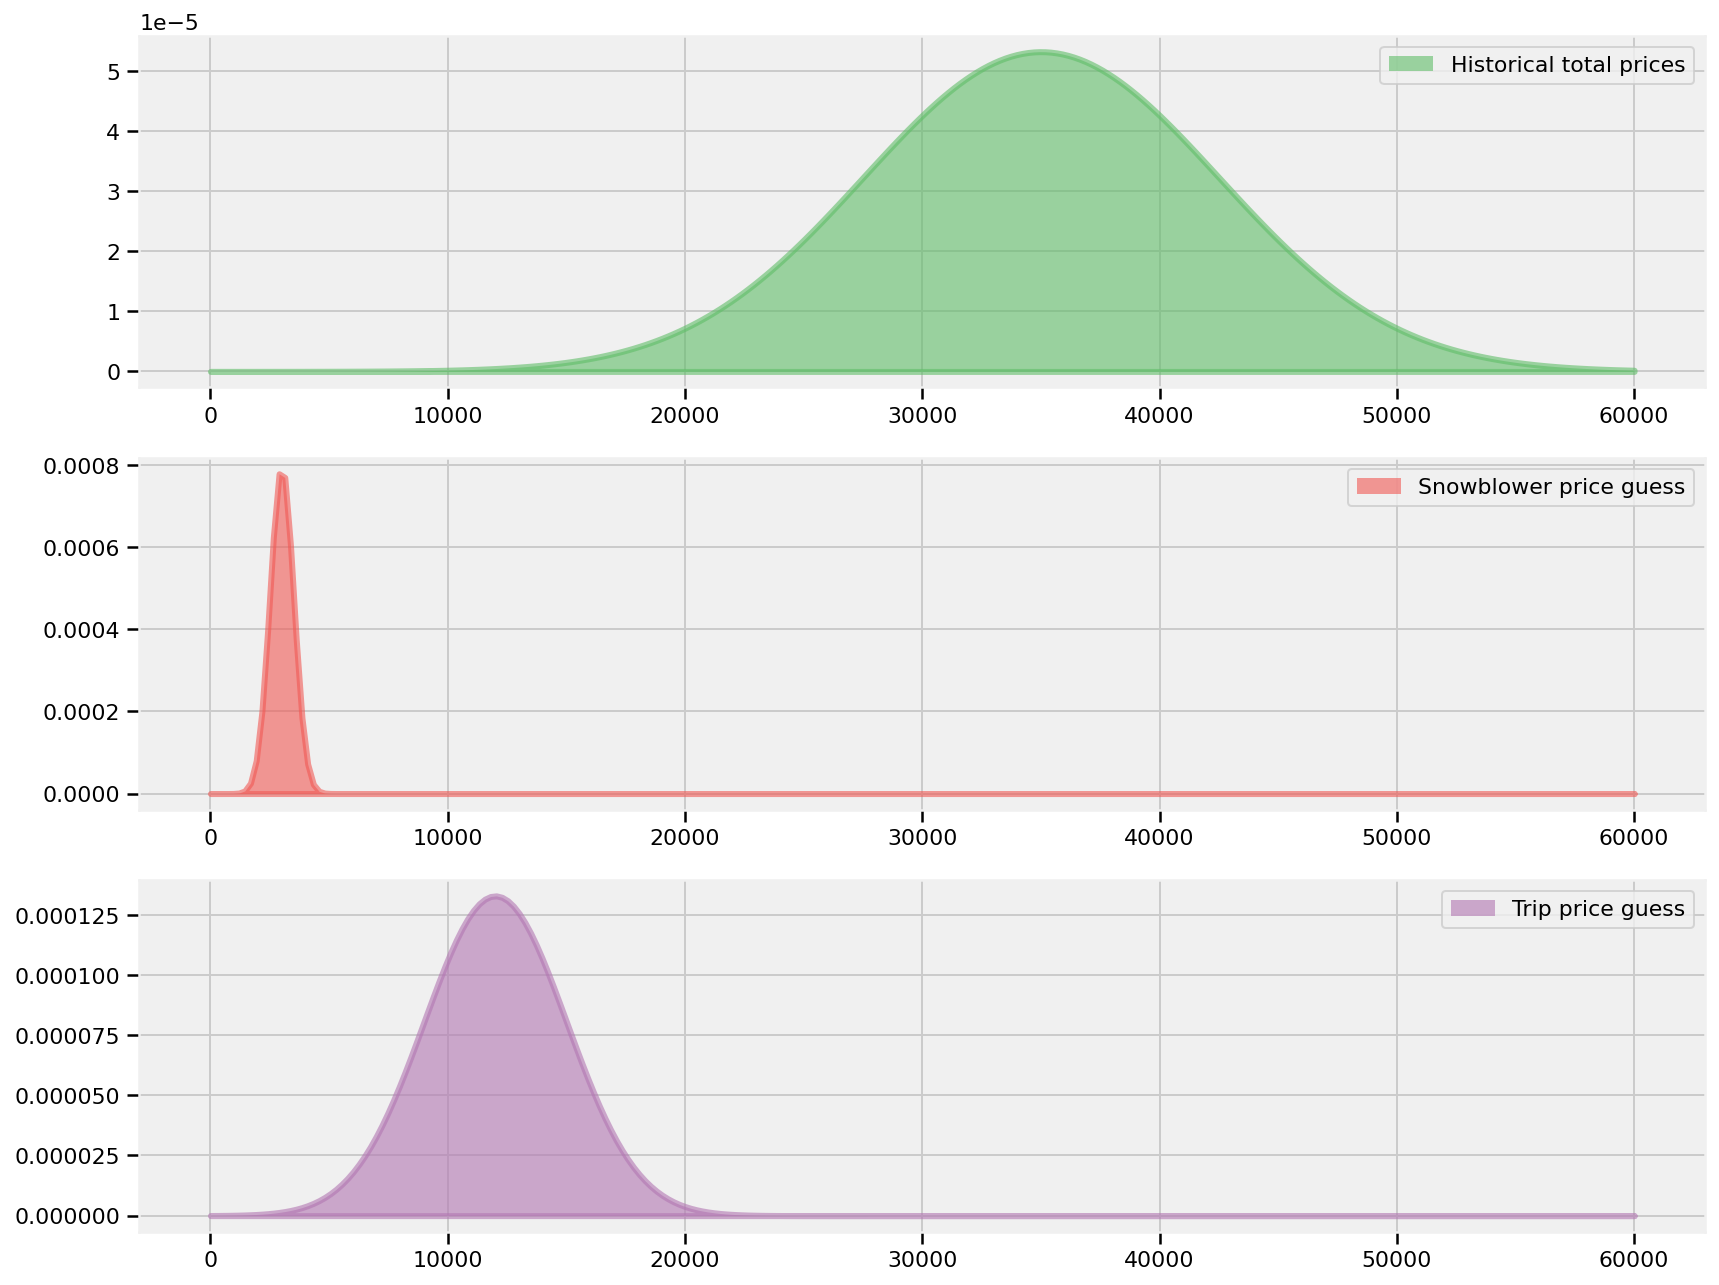

In [26]:
plt.figure(figsize(12.5, 11))

plt.subplot(311)
x = linspace(0., 60000., 250)

historical_prices = Normal(loc = 35000., scale = 7500.).prob(x)
snowblower_price_guesses = Normal(loc = 3000., scale = 500.).prob(x)
trip_price_guess = Normal(loc = 12000., scale = 3000.).prob(x)

sp1 = plt.fill_between(x, 0, historical_prices, color = TFColor[3], lw = 3, 
                       alpha = .6, label = "Historical total prices")
    
p1 = plt.Rectangle((0, 0), 1, 1, fc = sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
sp2 = plt.fill_between(x, 0, snowblower_price_guesses, color = TFColor[0], 
                       lw = 3, alpha = .6, label = "Snowblower price guess")
    
p2 = plt.Rectangle((0, 0), 1, 1, fc = sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
sp3 = plt.fill_between(x, 0, trip_price_guess, color = TFColor[6], lw = 3, 
                       alpha = .6, label = "Trip price guess")
p3 = plt.Rectangle((0, 0), 1, 1, fc = sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

In [27]:
data_loc = [3000., 12000.]
data_scale = [500., 3000.]

loc_prior = 35000.
scale_prior = 7500.
    
def posterior_log_prob(true_price, prize_1, prize_2):
    """Our posterior log probability, as a function of states
    
    Args:
      true_price_: scalar of true price estimate, taken from state
      prize_1: scalar of prize 1 estimate, to be added to the  prize 1 
        estimate, taken from state
      prize_2: scalar of prize 2 estimate, to be added to the prize 1 
        estimate, taken from state
    Returns: 
      Scalar sum of log probabilities
    Closure over: data_loc, data_scale, loc_prior, scale_prior
    """
    rv_true_price = Normal(loc = loc_prior, scale = scale_prior)
    rv_prize_1 = Normal(loc = data_loc[0], scale = data_scale[0])
    rv_prize_2 = Normal(loc = data_loc[1], scale = data_scale[1])
    price_estimate = prize_1 + prize_2
    rv_error = Normal(loc = price_estimate, scale = 3000.)
    
    return (
          rv_true_price.log_prob(true_price)
        + rv_prize_1.log_prob(prize_1)
        + rv_prize_2.log_prob(prize_2)
        + rv_error.log_prob(true_price))

In [28]:
num_results = 50000
num_burnin_steps = 10000

(true_price, prize_1, prize_2), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = [
        full((1,), 20000.),
        full((1,), 3000.),
        full((1,), 12000.)],
    kernel = tfp.mcmc.RandomWalkMetropolis(
        # Specify a new callable that has the appropriate step size
        new_state_fn = tfp.mcmc.random_walk_normal_fn(scale = 1000.),
        target_log_prob_fn = posterior_log_prob),
    parallel_iterations = 1,
    seed = random.PRNGKey(0))

posterior_price_predictive_samples = true_price[:, 0]

# Performing computations
# Can take up to 2 minutes in Graph Mode

#  For metropolis hastings the acceptance probability should be around 0.234.
#  See https://arxiv.org/pdf/1011.6217.pdf 
# print("Acceptance rate:", mean(kernel_results.inner_results.inner_results.is_accepted))
# print("Final step size:", kernel_results.new_step_size[-100:].mean())

print("posterior_price_predictive_sample trace:\n   ", posterior_price_predictive_samples)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


posterior_price_predictive_sample trace:
    [21141.94  22031.936 22031.936 ... 23656.396 23167.975 23167.975]


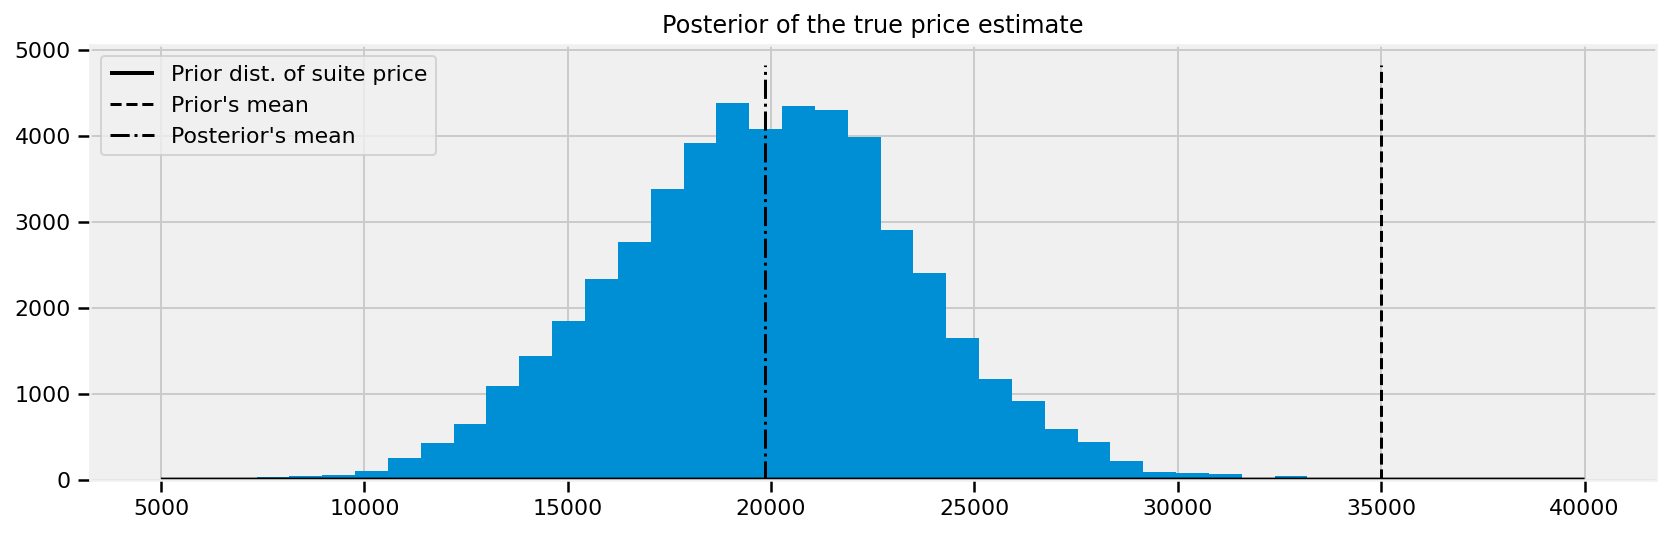

In [29]:
plt.figure(figsize(12.5, 4))
prices = linspace(5000., 40000., 35000)
prior = Normal(loc = 35000., scale = 7500.).prob(prices)

plt.plot(prices, prior, c = 'k', lw = 2,
         label = "Prior dist. of suite price")

hist = plt.hist(posterior_price_predictive_samples, bins = 35, histtype = 'stepfilled')
plt.title("Posterior of the true price estimate")
plt.vlines(loc_prior, 0, 1.1 * max(hist[0]), label = "Prior's mean",
           linestyles = '--')
plt.vlines(mean(posterior_price_predictive_samples), 0, 1.1 * max(hist[0]),
           label = "Posterior's mean", linestyles = '-.')
plt.legend(loc = 'upper left');

Notice that because of our two observed prizes and subsequent guesses (including uncertainty about those guesses), we shifted our mean price estimate down about $15 000 dollars from the previous mean price.

A frequentist, seeing the two prizes and having the same beliefs about their prices, would bid $\mu_1 + \mu_2 = 35000$, regardless of any uncertainty. Meanwhile, the *naive Bayesian* would simply pick the mean of the posterior distribution. But we have more information about our eventual outcomes; we should incorporate this into our bid. We will use the loss function above to find the *best* bid (*best* according to our loss).

What might a contestant's loss function look like? I would think it would look something like:

```python
def showcase_loss(guess, true_price, risk = 80000):
    if true_price < guess:
        return risk
    elif abs(true_price - guess) <= 250:
        return -2 * abs(true_price)
    else:
        return abs(true_price - guess - 250)
```

where `risk` is a parameter that defines of how bad it is if your guess is over the true price. A lower `risk` means that you are more comfortable with the idea of going over. If we do bid under and the difference is less than $250, we receive both prizes (modeled here as receiving twice the original prize). Otherwise, when we bid under the `true_price` we want to be as close as possible, hence the `else` loss is a increasing function of the distance between the guess and true price.

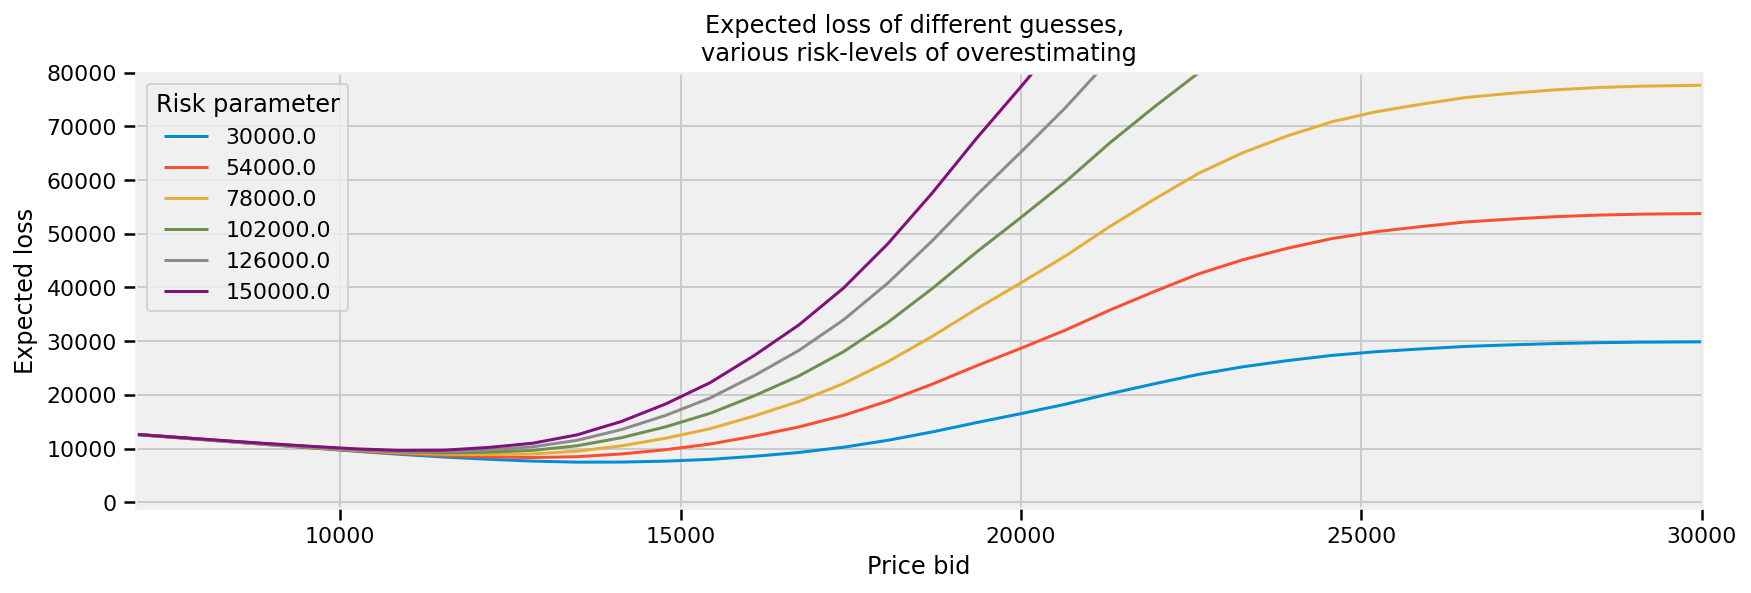

In [30]:
def showdown_loss(guess, size, true_price, risk = 80000):
    """Stock Loss function.

    Args:
        guess: float32 Tensor, representing a range of guesses for the price, or one guess
        size: int size of guess
        true_price: float32 Tensor of size 50000 x num_guesses, representing the 
            prices from the HMC sampling, broadcast to each of the num_guesses guesses           
        risk: a scalar value representing a penalizer for a score going over
            (lower risk indicates more comfort with the price going over)

    Returns:
        loss: tensor of shape (true_price.shape,guess.shape), returning the loss function per definition in accompanying text
    """
    true_price = transpose(broadcast_to(true_price, (size, true_price.shape[0])))
    risk = broadcast_to(array(risk, dtype = f32), true_price.shape)
    return where(true_price < guess,
                    risk,
                    where(abs(true_price - guess) <= 1,
                             -2 * abs(true_price),
                             abs(true_price - guess - 250)))
       
num_guesses = 70
num_risks = 6
guesses = linspace(5000., 50000., num_guesses) 
risks = linspace(30000, 150000, num_risks)
results_cache = zeros((num_risks, num_guesses))

def expected_loss(guess, size, risk):
    return mean(
        showdown_loss(guess, size, posterior_price_predictive_samples, risk),
        axis = 0)

risk_num = 0
for risk in risks:
    results = expected_loss(guesses, num_guesses, risk)
    plt.plot(guesses, results, label = str(risk))
    results_cache.at[risk_num, :].set(results)
    risk_num += 1
plt.title("Expected loss of different guesses, \nvarious risk-levels of overestimating")
plt.legend(loc = 'upper left', title = "Risk parameter")
plt.xlabel("Price bid")
plt.ylabel("Expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

For every possible bid, we calculate the *expected loss* associated with that bid. We vary the `risk` parameter to see how it affects our loss:

### Minimising our losses

It would be wise to choose the estimate that minimises our expected loss. This corresponds to the minimum point on each of the curves above. More formally, we would like to minimise our expected loss by finding the solution to

$$ \text{arg} \min_{\hat{\theta}} E_{\theta}\left[ L(\theta, \hat{\theta}) \right] $$

The minimum of the expected loss is called the *Bayes action*. 

We'll compute the minimum loss for the *Showcase* example above:

NameError: ignored

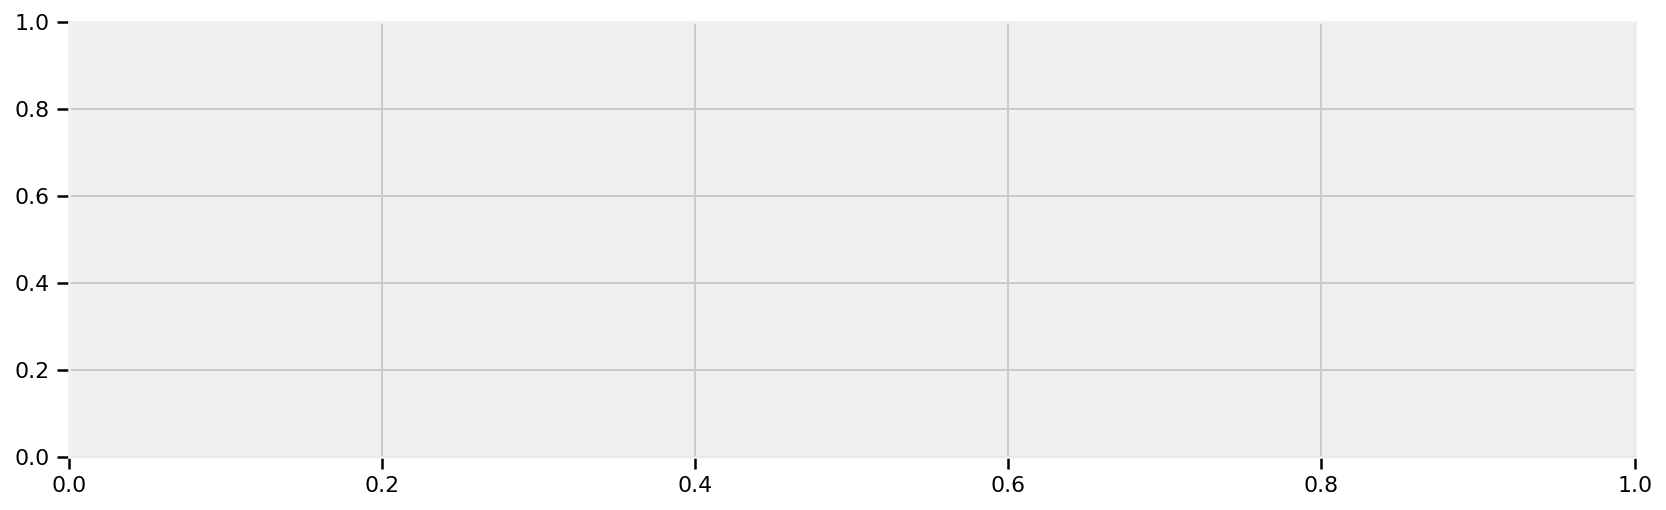

In [31]:
ax = plt.subplot(111)

risk_num = 0

for _p in risks:  
    color = next(ax._get_lines.prop_cycler)
    results = results_cache[risk_num, :]
    value = tf.Variable(15000., trainable = True)

    loss = -expected_loss(value, 1, tf.constant(_p, dtype = f32))
    optimizer = tf.optimizers.Adam(10)
    opt_min = optimizer.minimize(loss, var_list = [value])
    min_losses = []
    min_values = []
    for i in range(500):
        min_losses.append(loss)
        min_values.append(value)
    min_losses = asarray(min_losses)
    min_values = asarray(min_values)
    min_results = min_values[argmax(min_losses)]
    plt.plot(guesses, results , color= color['color'])
    plt.scatter(min_results, 0, s = 60,
                color = color['color'], label = str(_p))
    plt.vlines((min_results), 0, 120000, color= color['color'], linestyles = '--')
    print(f"minimum at risk {_p}: {min_results:.2f}")
    risk_num += 1
                                    
plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc = "upper left", scatterpoints = 1, title = "Bayes action at risk:")
plt.xlabel("Price guess")
plt.ylabel("Expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);


As intuition suggests, as we decrease the risk threshold (care about overbidding less), we increase our bid, willing to edge closer to the true price. It is interesting how far away our optimised loss is from the posterior mean, which was about 20 000. 

Suffice to say, in higher dimensions being able to eyeball the minimum expected loss is impossible. 


### Shortcuts

For some loss functions, the Bayes action is known in closed form. We list some of them below:

-  If using the mean-squared loss, the Bayes action is the mean of the posterior distribution, i.e. the value 
$$ E_{\theta}\left[ \theta \right] $$

>  minimises $E_{\theta}\left[ (\theta - \hat{\theta})^2 \right]$. Computationally this requires us to calculate the average of the posterior samples [See chapter 4 on The Law of Large Numbers]

-  Whereas the *median* of the posterior distribution minimises the expected absolute-loss. The sample median of the posterior samples is an appropriate and very accurate approximation to the true median.

-  In fact, it is possible to show that the MAP estimate is the solution to using a loss function that shrinks to the zero-one loss.


Maybe it is clear now why the first-introduced loss functions are used most often in the mathematics of Bayesian inference: no complicated optimisations are necessary. Luckily, we have machines to do the complications for us. 

## Machine Learning via Bayesian Methods

Whereas frequentist methods strive to achieve the best precision about all possible parameters, machine learning cares to achieve the best *prediction* among all possible parameters. Of course, one way to achieve accurate predictions is to aim for accurate predictions, but often your prediction measure and what frequentist methods are optimising for are very different. 

For example, least-squares linear regression is the most simple active machine learning algorithm. I say active as it engages in some learning, whereas predicting the sample mean is technically *simpler*, but is learning very little if anything. The loss that determines the coefficients of the regressors is a squared-error loss. On the other hand, if your prediction loss function (or score function, which is the negative loss) is not a squared-error, like AUC, ROC, precision, etc., your least-squares line will not be optimal for the prediction loss function. This can lead to prediction results that are suboptimal. 

Finding Bayes actions is equivalent to finding parameters that optimise *not parameter accuracy* but an arbitrary performance measure, however we wish to define performance (loss functions, AUC, ROC, precision/recall etc.).

The next two examples demonstrate these ideas. The first example is a linear model where we can choose to predict using the least-squares loss or a novel, outcome-sensitive loss. 

The second example is adapted from a Kaggle data science project. The loss function associated with our predictions is incredibly complicated. 

# Example: Financial prediction


Suppose the future return of a stock price is very small, say 0.01 (or 1%). We have a model that predicts the stock's future price, and our profit and loss is directly tied to us acting on the prediction.  How should we measure the loss associated with the model's predictions, and subsequent future predictions? A squared-error loss is agnostic to the signage and would penalise a prediction of -0.01 equally as bad a prediction of 0.03:

$$ (0.01 - (-0.01))^2 = (0.01 - 0.03)^2 = 0.004$$

If you had made a bet based on your model's prediction, you would have earned money with a prediction of 0.03, and lost money with a prediction of -0.01, yet our loss did not capture this. We need a better loss that takes into account the *sign* of the prediction and true value. We design a new loss that is better for financial applications below:

In [ ]:
plt.figure(figsize(12.5, 6.5))

def stock_loss(true_return, yhat, alpha = 100.):
    """Stock Loss function
    
    Args:
      true_return: float32 Tensor representing the true stock return
      yhat: float32
      alpha: float32
      
    Returns:
      float: absolute value of the difference
      between `true_return` and `yhat`
    """
    if true_return * yhat < 0:
        # opposite signs, not good
        return alpha * yhat ** 2 - sign(true_return) * yhat \
            + abs(true_return)
    else:
        return abs(true_return - yhat)


true_value_0 = .05
true_value_1 = -.02
pred = linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value_0, p) for p in pred],
         label = "Loss associated with\n prediction if true value = 0.05", lw = 3)
plt.vlines(0, 0, .25, linestyles = '--')
plt.xlabel('Prediction')
plt.ylabel('Loss')
plt.xlim(-.04, .12)
plt.ylim(0, .25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value_1, p) for p in pred], alpha = .6,
         label = "Loss associated with\n prediction if true value = -0.02", lw = 3)
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");

Note the change in the shape of the loss as the prediction crosses zero. This loss reflects that the user really does not want to guess the wrong sign, especially be wrong *and* a large magnitude. 

Why would the user care about the magnitude? Why is the loss not 0 for predicting the correct sign? Surely, if the return is 0.01 and we bet millions we will still be (very) happy.

Financial institutions treat downside risk, as in predicting a lot on the wrong side, and upside risk, as in predicting a lot on the right side, similarly. Both are seen as risky behaviour and discouraged. Hence why we have an increasing loss as we move further away from the true price. (With less extreme loss in the direction of the correct sign.)

We will perform a regression on a trading signal that we believe predicts future returns well. Our dataset is artificial, as most financial data is not even close to linear. Below, we plot the data along with the least-squares line.

In [ ]:
# Code for creating artificial 'dummy' data
# This is a common strategy for testing our models
# before applying it to real-world data

num_data = 100
X_data = .025 * Normal(loc = 0., scale = 1.).sample(sample_shape = (num_data,))
Y_data = .5 * X_data + .01 * Normal(loc = 0., scale = 1.).sample(sample_shape = (num_data,))

tf_var_data = tf.nn.moments(X_data, axes = 0)[1]
covar = tfp.stats.covariance(X_data, Y_data, sample_axis = 0, event_axis = None)
ls_coef = covar / tf_var_data

ls_intercept = mean(Y_data) - ls_coef * mean(X_data)

plt.figure(figsize(12.5, 7))
plt.scatter(X_data, Y_data, c = 'k')
plt.xlabel('Trading signal')
plt.ylabel('Returns')
plt.title("Empirical returns vs trading signal")
plt.plot(X_data, ls_coef * X_data + ls_intercept, label = "Least-squares line")
plt.xlim(min(X_data), max(X_data))
plt.ylim(min(Y_data), max(Y_data))
plt.legend(loc = 'upper left');

We perform a simple Bayesian linear regression on this dataset. We look for a model like:

$$ R = \alpha + \beta x + \epsilon$$

where $\alpha, \beta$ are our unknown parameters and $\epsilon \sim \text{Normal}(0, 1/\tau)$. The most common priors on $\beta$ and $\alpha$ are Normal priors. We will also assign a prior on $\tau$, so that $\sigma = 1/\sqrt{\tau}$ is uniform over 0 to 100 (equivalently then $\tau = 1/\text{Uniform}(0, 100)^2$).

In [ ]:
obs_stdev = sqrt(
    mean(tf.math.squared_difference(Y_data, mean(Y_data, axis = 0)),
            axis = 0))

# Define the log probability of the bayesian regression function
def finance_posterior_log_prob(X_data, Y_data, alpha, beta, sigma):
    """Posterior log probability, as a function of states
    
    Args:
      alpha_: scalar, taken from state of the HMC
      beta_: scalar, taken from state of the HMC
      sigma_: scalar, the standard deviation of , taken from state of the HMC
    Returns: 
      Scalar sum of log probabilities
    Closure over: Y_data, X_data
    """
    rv_alpha = Normal(loc = 0., scale = 100.)
    rv_beta = Normal(loc = 0., scale = 100.)
    rv_std = Uniform(low = 0., high = 100.)
    mean = alpha + beta * X_data
    rv_observed = Normal(loc = mean, scale = sigma)
    
    return (
          rv_alpha.log_prob(alpha) 
        + rv_beta.log_prob(beta) 
        + rv_std.log_prob(sigma)
        + sum(rv_observed.log_prob(Y_data)))

In [ ]:
num_results = 5000
num_burnin_steps = 1000

# Set the chain's start state.
initial_chain_state = [
    1. * ones(()),  # TODO f32
    .01 * ones(()),  # TODO f32
    obs_stdev * ones(())]  # TODO f32

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
# Beta and sigma are 100x and 10x of alpha, approximately, so apply Affine scalar bijector
# to multiply the unconstrained beta and sigma by 100x and 10x to get back to 
# the problem space
unconstraining_bijectors = [
    tfb.Identity(),  # alpha
    tfb.AffineScalar(100.),  # beta
    tfb.AffineScalar(10.)]  # sigma

# Define a closure over the joint_log_prob
def unnormalised_posterior_log_prob(*args):
    return finance_posterior_log_prob(X_data, Y_data, *args)

# Initialise the step_size (it will be automatically adapted.)
step_size = tf.Variable(
    initial_value = tf.constant(.5, dtype = f32),
    trainable = False,
    name = 'step_size')

# Define the HMC
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalised_posterior_log_prob,
        num_leapfrog_steps = 2,
        step_size = step_size,
        state_gradients_are_stopped = True),
    bijector = unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = kernel,
    num_adaptation_steps = int(num_burnin_steps * .8))

# Sample from the chain
(alpha,  beta,  sigma), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = kernel)

# performing computations
# can take up to about 4 mins in graph mode
# print("Acceptance rate:", mean(kernel_results.inner_results.inner_results.is_accepted))
# print("Final step size:", kernel_results.new_step_size[-100:].mean())

In [ ]:
# Plotting the Posterior Samples
plt.figure(figsize = (15, 3))
plt.plot(arange(num_results), sigma, color = TFColor[6])
plt.title('HMC sigma (σ) convergence progression', fontsize = 14)

plt.figure(figsize = (15, 3))
plt.plot(arange(num_results), beta, color = TFColor[0])
plt.title('HMC beta (β) convergence progression', fontsize = 14)

plt.figure(figsize = (15, 3))
plt.plot(arange(num_results), alpha, color = TFColor[3])
plt.title('HMC alpha (α) convergence progression', fontsize = 14)

In [ ]:
# Plotting the Posterior Samples

plt.figure(figsize = (15, 12))
plt.subplot(3, 2, 1)
plt.hist(sigma, 
         bins = 100, color = TFColor[6], alpha = .8)
plt.ylabel('Frequency')
plt.title('Posterior std (σ) samples', fontsize = 14)
plt.subplot(3, 2, 2)
plt.plot(arange(num_results), 
         sigma, color = TFColor[6], alpha = .8)
plt.ylabel('Sample Value')
plt.title('Posterior std (σ) samples', fontsize = 14)

plt.subplot(3, 2, 3)
plt.hist(beta, 
         bins = 100, color = TFColor[0], alpha = .8)
plt.ylabel('Frequency')
plt.title('Posterior beta (β) samples', fontsize = 14)
plt.subplot(3, 2, 4)
plt.plot(arange(num_results), 
         beta, color = TFColor[0], alpha = .8)
plt.ylabel('Sample Value')
plt.title('Posterior beta (β) samples', fontsize = 14)

plt.subplot(3, 2, 5)
plt.hist(alpha, bins = 100, 
         color = TFColor[3], alpha = .8)
plt.ylabel('Frequency')
plt.title('Posterior alpha (α) samples', fontsize = 14)
plt.subplot(3, 2, 6)
plt.plot(arange(num_results), alpha, 
         color = TFColor[3], alpha = .8)
plt.ylabel('Sample Value')
plt.title('Posterior alpha (α) samples', fontsize = 14)

# KDE Plots
plt.figure(figsize = (15,9))
plt.subplot(2, 2, 1)
ax1 = sns.kdeplot(sigma, 
                  shade = True, color = TFColor[6], bw = .000075)
plt.ylabel('Probability density')
plt.title('KDE plot for std (σ)', fontsize = 14)
plt.subplot(2, 2, 2)
ax2 = sns.kdeplot(beta, 
                  shade = True, color = TFColor[0], bw = .0030)
plt.ylabel('Probability density')
plt.title('KDE plot for beta (β) samples', fontsize = 14)
plt.subplot(2, 2, 3)
ax3 = sns.kdeplot(alpha, 
                  shade = True, color = TFColor[3], bw = .0001)
plt.ylabel('Probability density')
plt.title('KDE plot for alpha (α) samples', fontsize = 14)

It appears the MCMC has converged so we may continue.

For a specific trading signal, call it $x$, the distribution of possible returns has the form:

$$ R_i(x) =  \alpha_i + \beta_ix + \epsilon $$

where $\epsilon \sim \text{Normal}(0, 1/\tau_i) $ and $i$ indexes our posterior samples. We wish to find the solution to 

$$ \arg \min_{r} E_{R(x)}\left[ L(R(x), r) \right] $$

according to the loss given above. This $r$ is our Bayes action for trading signal $x$. Below we plot the Bayes action over different trading signals. What do you notice?


In [ ]:
plt.figure(figsize(12.5, 6))

def stock_loss(
    price, pred, coef = 500):
    """Vectorised Stock Loss function
    
    Args:
        price: A (<num_results>,) Tensor of prices (independent variable)
        pred: A (1,) Tensor prediction based on the price
        coef: Integer Tensor representing coeficient for Bayes action function
    Returns:
        sol: A (<num_results>,) array Tensor of data points for Bayes action solution minima
    """
    sol = zeros_like(price)
    ix = price * pred < 0
    sol[ix] = coef * pred ** 2 - sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

N = sigma.shape[0]
noise = sigma * Normal(loc = 0., scale = 1.).sample(N)

possible_outcomes = lambda signal: alpha + beta * signal + noise

opt_predictions = zeros(50)
trading_signals = linspace(min(X_data), max(X_data), 50)
for i, signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = minimize(tomin, 0, disp = False)
    
plt.xlabel("Trading signal")
plt.ylabel("Prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X_data, ls_coef * X_data + ls_intercept, label = "Least-squares prediction")
plt.xlim(min(X_data), max(X_data))
plt.plot(trading_signals, opt_predictions, label = "Bayes action prediction")
plt.legend(loc = 'upper left');

What is interesting about the above graph is that when the signal is near 0, and many of the possible  returns outcomes are possibly both positive and negative, our best (with respect to our loss) prediction is to predict close to 0, hence *take on no position*. Only when we are very confident do we enter into a position. I call this style of model a *sparse prediction*, where we feel uncomfortable with our uncertainty so choose not to act. (Compare with the least-squares prediction which will rarely, if ever, predict zero). 

A good sanity check that our model is still reasonable: as the signal becomes more and more extreme, and we feel more and more confident about the positive/negativeness of returns, our position converges with that of the least-squares line. 

The sparse-prediction model is not trying to *fit* the data the best (according to a *squared-error loss* definition of *fit*). That honor would go to the least-squares model. The sparse-prediction model is trying to find the best prediction *with respect to our `stock_loss`-defined loss*. We can turn this reasoning around: the least-squares model is not trying to *predict* the best (according to a *`stock-loss`* definition of *predict*). That honor would go the *sparse prediction* model. The least-squares model is trying to find the best fit of the data *with respect to the squared-error loss*.

# Example: Kaggle contest on *Observing Dark World*


A personal motivation for learning Bayesian methods was trying to piece together the winning solution to Kaggle's [*Observing Dark Worlds*](http://www.kaggle.com/c/DarkWorlds) contest. From the contest's website:



>There is more to the Universe than meets the eye. Out in the cosmos exists a form of matter that outnumbers the stuff we can see by almost 7 to 1, and we don’t know what it is. What we do know is that it does not emit or absorb light, so we call it Dark Matter. Such a vast amount of aggregated matter does not go unnoticed. In fact we observe that this stuff aggregates and forms massive structures called Dark Matter Halos. Although dark, it warps and bends spacetime such that any light from a background galaxy which passes close to the Dark Matter will have its path altered and changed. This bending causes the galaxy to appear as an ellipse in the sky.

<img src = "http://timsalimans.com/wp-content/uploads/2012/12/dm.jpg">


The contest required predictions about where dark matter was likely to be. The winner, [Tim Salimans](http://timsalimans.com/), used Bayesian inference to find the best locations for the halos (interestingly, the second-place winner also used Bayesian inference). With Tim's permission, we provided his solution [1] here:

1. Construct a prior distribution for the halo positions $p(x)$, i.e. formulate our expectations about the halo positions before looking at the data.
2. Construct a probabilistic model for the data (observed ellipticities of the galaxies) given the positions of the dark matter halos: $p(e | x)$.
3. Use Bayes’ rule to get the posterior distribution of the halo positions, i.e. use to the data to guess where the dark matter halos might be.
4. Minimise the expected loss with respect to the posterior distribution over the predictions for the halo positions: $\hat{x} = \arg \min_{\text{prediction} } E_{p(x|e)}[ L( \text{prediction}, x) ]$ , i.e. tune our predictions to be as good as possible for the given error metric.


The loss function in this problem is very complicated. For the very determined, the loss function is contained in the file DarkWorldsMetric.py in the parent folder. Though I suggest not reading it all, suffice to say the loss function is about 160 lines of code &mdash; not something that can be written down in a single mathematical line. The loss function attempts to measure the accuracy of prediction, in a Euclidean distance sense, such that no shift-bias is present. More details can be found on the metric's [main page](http://www.kaggle.com/c/DarkWorlds/details/evaluation). 

We will attempt to implement Tim's winning solution using [Tensorflow Probability](https://medium.com/tensorflow/introducing-tensorflow-probability-dca4c304e245) and our knowledge of loss functions.

In [ ]:
# Downloading the zip file containing the Galaxy Data
url1 = 'https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/data.zip?raw = true'
filename1 = wget.download(url1)
filename1

In [ ]:
!unzip -q data.zip -d data

We also want to import the data files and Loss functions specific to this Kaggle Competition. You can download the files directly from the [Observing Dark Worlds competition's Data page](https://www.kaggle.com/c/DarkWorlds/data) or, if you already have a Kaggle account, install the [Kaggle API](https://github.com/Kaggle/kaggle-api) and run the following terminal command:

```
kaggle competitions download -c DarkWorlds
```

And once the competition information is available locally, we can simply unzip the data.


One last thing to set up is the function we use for plotting galaxies from the files, which we define here:

#### Defining our galaxy-plotting function

In [ ]:
def draw_sky(galaxies):
    """From a given file of galaxy data, 
    plots the shapes and positions of galaxies.
    
    Args:
      galaxies: 4-column, float32 Numpy array containing x-coordinates, y-coordinates,
        and the two axes of ellipcity.
    Returns:
      fig: image of galaxy plot
    """
    size_multiplier = 45
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, aspect = 'equal')
    n = galaxies.shape[0]
    for i in range(n):
        g = galaxies[i, :]
        x, y = g[0], g[1]
        d = sqrt(g[2] ** 2 + g[3] ** 2)
        a = 1.0 / (1 - d)
        b = 1.0 / (1 + d)
        theta = degrees(arctan2(g[3], g[2]) * 0.5)
        
        ax.add_patch(Ellipse(xy = (x, y), width = size_multiplier * a, height = size_multiplier * b, angle = theta))
    ax.autoscale_view(tight = True)
    
    return fig

### Examining Our Data

The dataset is actually 300 separate files, each representing a sky. In each file, or sky, are between 300 and 720 galaxies. Each galaxy has an $x$ and $y$ position associated with it, ranging from 0 to 4200, and measures of ellipticity: $e_1$ and $e_2$. Information about what these measures mean can be found [here](https://www.kaggle.com/c/DarkWorlds/details/an-introduction-to-ellipticity), but for our purposes it does not matter besides for visualization purposes. Thus a typical sky might look like the following:

In [ ]:
num_sky = 3  # choose a file/sky to examine
data = genfromtxt(f'data/Train_Skies/Train_Skies/Training_Sky{num_sky}.csv',
                      dtype = f32,
                      skip_header = 1,
                      delimiter = ',',
                      usecols = [1, 2, 3, 4])
              # It's handy to specify the data type beforehand

galaxy_positions = array(data[:, :2], dtype = f32)
gal_ellipticities = array(data[:, 2:], dtype = f32)
ellipticity_mean = mean(data[:, 2:], axis = 0)
ellipticity_stddev = std(data[:, 2:], axis = 0)
num_galaxies = array(galaxy_positions).shape[0]

print(f"Data on galaxies in sky {num_sky}.")
print("position_x, position_y, e_1, e_2 ")
print(data[:3])
print("Number of Galaxies: ", num_galaxies)
print("e_1 & e_2 mean: ", ellipticity_mean)
print("e_1 & e_2 std_dev: ", ellipticity_stddev)

Nice, as we can see above we have the data organized into columns according to their x and y coordinates, and the degrees of elipticity along each axis of the galaxies. If we want to reference the positions directly, we can use the following:

In [ ]:
fig = draw_sky(data)
plt.title(f"Galaxy positions and ellipcities of sky {num_sky}.")
plt.xlabel("x-position")
plt.ylabel("y-position");


...beautiful!


### Priors

Each sky has one, two or three dark matter halos in it. Tim's solution details that his prior distribution of halo positions was uniform, i.e.
$$
\begin{align}
& x_i \sim \text{Uniform}( 0, 4200)\\
& y_i \sim \text{Uniform}( 0, 4200), \;\; i = 1,2,3\\
\end{align}
$$
Tim and other competitors noted that most skies had one large halo and other halos, if present, were much smaller. Larger halos, having more mass, will influence the surrounding galaxies more. He decided that the large halos would have a mass distributed as a *log*-uniform random variable between 40 and 180 i.e.

$$  m_{\text{large} } = \log \text{Uniform}( 40, 180 ) $$

and in Tensorflow Probability, 

```python
# Log-Uniform Distribution
mass_large = TransformedDistribution(
    distribution = Uniform(low = 40.0, high = 180.0),
    bijector = tfb.Exp())
```

(This is what we mean when we say *log*-uniform.) For smaller galaxies, Tim set the mass to be the logarithm of 20. Why did Tim not create a prior for the smaller mass, nor treat it as a unknown? I believe this decision was made to speed up convergence of the algorithm. This is not too restrictive, as by construction the smaller halos have less influence on the galaxies.

Tim logically assumed that the ellipticity of each galaxy is dependent on the position of the halos, the distance between the galaxy and halo, and the mass of the halos. Thus the vector of ellipticity of each galaxy, $\mathbf{e}_i$, are *children* variables of the vector of halo positions $(\mathbf{x},\mathbf{y})$, distance (which we will formalize), and halo masses.

Tim conceived a relationship to connect positions and ellipticity by reading literature and forum posts. He supposed the following was a reasonable relationship:

$$ e_i | ( \mathbf{x}, \mathbf{y} ) \sim \text{Normal}( \sum_{j = \text{halo positions} }d_{i,j} m_j f( r_{i,j} ), \sigma^2 ) $$

where $d_{i,j}$ is the *tangential direction* (the direction in which halo $j$ bends the light of galaxy $i$), $m_j$ is the mass of halo $j$, $f(r_{i,j})$ is a *decreasing function* of the Euclidean distance between halo $j$ and galaxy $i$. 

The variance, or $\sigma^2$, was simply estimated to be 0.05 from eyeballing the data. This means the Standard deviation (SD) of the measurement of $e_i$ for the full range of $i$ works out to approximately 0.223607......

Tim's function $f$ was defined:

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 240 ) } $$

for large halos, and for small halos

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 70 ) } $$

This fully bridges our observations and unknown. This model is incredibly simple, and Tim mentions this simplicity was purposefully designed: it prevents the model from overfitting.  


### Training & Tensorflow implementation

For each sky, we run our Bayesian model to find the posteriors for the halo positions &mdash; we ignore the (known) halo position. This is slightly different than perhaps traditional approaches to Kaggle competitions, where this model uses no data from other skies nor the known halo location. That does not mean other data are not necessary &mdash; in fact, the model was created by comparing different skies. 

***Constructing a prior distribution for the halo positions $p(x)$, i.e. formulate our expectations about the halo positions before looking at the data.***

When constructing our prior and likelihood distributions, we're going to use these to set up a loss function that is very similar to that of a [Variational Auto Encoder](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py) (although a much lower-dimensional one).

In [ ]:
def euclidean_distance(x, y):
    """Calculates the euclidian distance between point x and poin y.
    
    Args:
      x: a Tensorflow tensor for element-wise
      calculation
      y: a Tensorflow tensor for element-wise
      calculation
    Returns: 
      a Tensor containing the euclidian 
      distance between x and y
    """
    return sqrt(sum(tf.squared_difference(x, y), axis = 1))


def f_distance(gxy_pos, halo_pos, c):
    """Provides our element-wise maximum as in NumPy, 
    but instead for TensorFlow tensors
    
    Args:
      gxy_pos: a 2-d numpy array of observed galaxy
        positions
      halo_pos: a 2-d numpy array with halo positions
      c: a scalar of shape order 0
    Returns: 
      Maximum of either the uclidian distance of gxy_pos
      & halo_pos, or the constant c.
    """
    return tf.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]


def tangential_distance(glxy_position, halo_position):
    """Calculates the tangential distance between coordinates glxy_position & halo_position.
    
    Args:
      glxy_position: a 2-d numpy array of observed galaxy
        positions
      halo_position: a 2-d numpy array with halo positions
    Returns: 
      vectors with direction of dominant halo.
    """
    
    x_delta, y_delta = tf.unstack(
        glxy_position - halo_position, num = 2, axis = -1)
    angle = 2. * atan(y_delta / x_delta)
    return stack([-cos(angle), -sin(angle)], axis = -1)

In [ ]:
def posterior_log_prob(mass_large, halo_pos):
    """Posterior log probability, as a function of states
    Closure over: data
    
    Args:
      mass_large: scalar of halo mass, taken from state
      halo_pos: tensor of halo position(s), taken from state
    Returns: 
      Scalar sum of log probabilities
    """
    rv_mass_large = Uniform(low = 40., high = 180.)    
    
    # Set the random size of the halo's mass (the big halo for now)
    # We use Independent to change the batch and event shapes
    rv_halo_pos = Independent(
        Uniform(low = (0., 0.), high = (4200., 4200.)),
        reinterpreted_batch_ndims = 1)
    ellpty_mvn_loc = (mass_large
                      / f_distance(data[:, :2], halo_pos, 240.)
                      * tangential_distance(data[:, :2], halo_pos))
    ellpty = MultivariateNormalDiag(
        loc = ellpty_mvn_loc, 
        scale_diag = (0.223607, 0.223607))
    
    return (sum(ellpty.log_prob(data[:, 2:]), axis = 0) + 
            rv_halo_pos.log_prob(halo_pos) + 
            rv_mass_large.log_prob(mass_large))

Let's go onto the next part:

***Constructing a probabilistic model for the data (observed ellipticities of the galaxies) given the positions of the dark matter halos: $p(e | x)$***

Given data, we use a Metropolis Random Walk (MRW) Markov chain Monte Carlo method to calculate the precise posterior distribution over the model's parameters. It is possible to use Hamiltoniam Monte Carlo (HMC) for problems like this, but Metropolis is more appropriate for this case due to its comparative simplicity.

Tim's model gives us an approximate posterior to start with. That is, we asume the posterior must be proportional to the normal distribution of distances inferred from galaxy ellipcities.


In [ ]:
# Infer the posterior distribution

num_results = 10000
num_burnin_steps = 5000

# Set the chain's start state
initial_chain_state = [
    fill((1,), 80.),
    fill((1, 2), 2100.)]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity()]

# Define a closure over our joint_log_prob
unnormalised_posterior_log_prob = lambda *args: posterior_log_prob(*args)

# Initialise the step_size (it will be automatically adapted.)
step_size = tf.Variable(
    initial_value = tf.constant(.06, dtype = f32),
    trainable = False,
    name = 'step_size')

kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalised_posterior_log_prob,
        num_leapfrog_steps = 6,
        step_size = step_size)

kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel = kernel,
    bijector = unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = kernel,
    num_adaptation_steps = int(num_burnin_steps * .8))

# Sampling from the chain
(mass_large, posterior_predictive_samples), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = kernel)

We new have the setup for our probabilistic model. We can now go onto the third step:


#### Using Bayes’ rule to get the posterior distribution of the halo positions, i.e. use to the data to guess where the dark matter halos might be.

We're going to take the results of the outputs of the Markov chain, take the mean and standard deviation, and then use those to create a lower-dimensional multivariate normal distribution of halo distributions. This will be our posterior predictive distribution.

First, we can create the convenience functions to set up our session

In [ ]:
# print("Acceptance rate:", mean(kernel_results.inner_results.inner_results.is_accepted))
# print("Final step size:", kernel_results.new_step_size[-100:].mean())
print("posterior_predictive_samples value:\n", posterior_predictive_samples)

Below we plot a "heatmap" of the posterior predictive distribution. (Which is just a scatter plot of the posterior, but we can visualise it as a heatmap.)

In [ ]:
t = posterior_predictive_samples.reshape(num_results, 2)
fig = draw_sky(data)
plt.title(f"Galaxy positions and ellipcities of sky {num_sky}.")
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.scatter(t[:, 0], t[:, 1], alpha = .015, c = '#F15854')  # Red
plt.xlim(0, 4200)
plt.ylim(0, 4200);

The most probable position reveals itself like a lethal wound.

Associated with each sky is another data point, located in `./data/Training_halos.csv` that holds the locations of up to three dark matter halos contained in the sky. For example, the night sky we trained on has halo locations:

In [ ]:
halo_data = genfromtxt('data/Training_halos.csv', 
                          delimiter = ',',
                          usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          skip_header = 1)
print(halo_data[num_sky])

The third and fourth column represent the true x and y position of the halo. It appears that the Bayesian method has located the halo within a tight vicinity.

In [ ]:
fig = draw_sky(data)
plt.title(f"Galaxy positions and ellipcities of sky {num_sky}.")
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:, 0], t[:, 1], alpha = .015, c = '#F15854') # Red
plt.scatter(halo_data[num_sky - 1][3], halo_data[num_sky - 1][4], 
            label = "True halo position",
            c = 'k', s = 70)
plt.legend(scatterpoints = 1, loc = 'lower left')
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[num_sky][3], halo_data[num_sky][4])

Perfect. Our next step is to use the loss function to optimise our location. A naive strategy would be to simply choose the mean:

In [ ]:
mean_posterior = t.mean(axis = 0).reshape(1, 2)
print(f"Mean posterior: \n {mean_posterior[0]}")

but we also want to determine how good this mean score is. We can use the [DarkWorldsMetric.py](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/DarkWorldsMetric.py) script to judge that.

In [ ]:
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter5_LossFunctions/DarkWorldsMetric.py'
filename = wget.download(url)
filename

In [ ]:
from DarkWorldsMetric import main_score

halo_data_sub = halo_data[num_sky - 1]

nhalo_all  = halo_data_sub[0].reshape(1, 1)
x_true_all = halo_data_sub[3].reshape(1, 1)
y_true_all = halo_data_sub[4].reshape(1, 1)
x_ref_all  = halo_data_sub[1].reshape(1, 1)
y_ref_all  = halo_data_sub[2].reshape(1, 1)
sky_prediction = mean_posterior

print("Using the mean:", sky_prediction[0])
main_score(nhalo_all, x_true_all, y_true_all,
           x_ref_all, y_ref_all, sky_prediction)

# What's a bad score?
random_guess = tfd.Independent(
    tfd.Uniform(low = (0., 0.), high = (4200., 4200.)),
    reinterpreted_batch_ndims = 1).sample()

print("\n Using a random location:", random_guess[0])
main_score(nhalo_all, x_true_all, y_true_all,
            x_ref_all, y_ref_all, random_guess)

This is a good guess, it is not very far from the true location, but it ignores the loss function that was provided to us. We also need to extend our code to allow for up to two additional, *smaller* halos: Let's create a function for automatizing our Tensorflow workflow from before. 

First let's reset our Tensorflow Graph and import the new dataset:


In [ ]:
num_sky = 215  # Choosing a file/sky to examine
data = genfromtxt(f'data/Train_Skies/Train_Skies/Training_Sky{num_sky}.csv',
                     dtype = f32,  # It's handy to specify the data type beforehand
                     skip_header = 1,
                     delimiter = ',',
                     usecols = [1, 2, 3, 4])

galaxy_positions = array(data[:, :2], dtype = f32)
gal_ellipticities = array(data[:, 2:], dtype = f32)
ellipticity_mean = mean(data[:, 2:], axis = 0)
ellipticity_stddev = std(data[:, 2:], axis = 0)
num_galaxies = array(galaxy_positions).shape[0]

print(f"Data on galaxies in sky {num_sky}.")
print("position_x, position_y, e_1, e_2")
print(data[:3])
print("Number of Galaxies:", num_galaxies)
print("e_1 & e_2 mean:", ellipticity_mean)
print("e_1 & e_2 std_dev:", ellipticity_stddev)


In [ ]:
def multi_posterior_log_prob(mass_large, halo_pos):
    """Our modified posterior log probability, as a function of states
    Closure over: data
    
    Args:
      mass_large: scalar of halo mass, taken from state
      halo_pos: tensor of halo position(s), taken from state
    Closure over: 
      data
    Returns: 
      Scalar sum of log probabilities
    """
    # Set the random size of the halo's mass (we have multiple)
    rv_mass_large = tfd.Uniform(low = 40., high = 180.)    
    rv_mass_small_0 = 20.
    rv_mass_small_1 = 20.
             
    # Set the initial prior positions of the halos, 
    # these are a set of 2-d Uniform distributions

    rv_halo_pos = tfd.Independent(
        tfd.Uniform(
            low = tf.cast(
                reshape(
                    tile([0., 0.], num_halos_inum_sky),
                    (num_halos_inum_sky, 2)),
                f32),
            high = tf.cast(
                reshape(
                    tile([4200., 4200.], num_halos_inum_sky),
                    (num_halos_inum_sky, 2)),
                f32)),
        einterpreted_batch_ndims = 1)  # Notice this size
      
    fdist_constants = array([240., 70., 70.])
       
    # For our calculations of ellipcity derived from halo position, we derive means based
    # on the sum of the means of forces from multiple halos

    mean_sum = 0
    mean_sum += (mass_large[0] / f_distance(data[:, :2], halo_pos[0, :], fdist_constants[0]) *
        tangential_distance(data[:, :2], halo_pos[0, :]))
    mean_sum += (rv_mass_small_0 / f_distance(data[:, :2], halo_pos[1, :], fdist_constants[1]) *
        tangential_distance(data[:,:2], halo_pos[1, :]))
    mean_sum += (rv_mass_small_1 / f_distance(data[:, :2], halo_pos[2, :], fdist_constants[2]) *
        tangential_distance(data[:, :2], halo_pos[2, :]))
        
    ellpty = tfd.MultivariateNormalDiag(
        loc = (mean_sum,),
        scale_diag = (0.223607, 0.223607))

    return (sum(ellpty.log_prob(data[:, 2:]), axis = 0) + 
            rv_halo_pos.log_prob(tf.cast(halo_pos[0, :], f32))[0] + 
            rv_halo_pos.log_prob(tf.cast(halo_pos[1, :], f32))[1] +
            rv_halo_pos.log_prob(tf.cast(halo_pos[2, :], f32))[2] + 
            rv_mass_large.log_prob(tf.cast(mass_large[0][0], f32)))


In [ ]:
# Inferring the posterior distribution
num_results = 5000
num_burnin_steps = 1000
num_leapfrog_steps = 6
    
# We have three halos in the sky instead of one
num_halos_inum_sky = 3

# Set the chain's start state
initial_chain_state = [
    tf.constant([80., 20., 20.],
                shape = (num_halos_inum_sky, 1), 
                dtype = f32),
    tf.constant([1000., 500., 2100., 1500., 3500., 4000.], 
                shape = (num_halos_inum_sky, 2), 
                dtype = f32)]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity()]

# Define a closure over our joint_log_prob
unnormalised_posterior_log_prob = lambda *args: multi_posterior_log_prob( *args)

# Initialise the step_size (it will be automatically adapted)
step_size = tf.Varible(
    initial_value = tf.constant(.6, dtype = f32),
    trainable = False,
    name = 'step_size')

# Define the HMC
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalised_posterior_log_prob,
        num_leapfrog_steps = num_leapfrog_steps,
        step_size = step_size,
        state_gradients_are_stopped = True),
    bijector = unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = kernel,
    num_adaptation_steps = int(num_burnin_steps * .8))

# Sampling from the chain
(mass_large, halo_pos), kernel_results = tfp.mcmc.sample_chain(
    num_results = num_results,
    num_burnin_steps = num_burnin_steps,
    current_state = initial_chain_state,
    kernel = kernel)

In [ ]:
large_halo_pos = halo_pos[:,0]
small1_halo_pos = halo_pos[:,1]
small2_halo_pos = halo_pos[:,2]

# print("Acceptance rate:", mean(kernel_results.inner_results.inner_results.is_accepted))
# print("Final step size:", kernel_results.new_step_size[-100:].mean())

In [ ]:
fig = draw_sky(data)
plt.title(f"Galaxy positions and ellipcities of sky {num_sky}.")
plt.xlabel("x-position")
plt.ylabel("y-position")

# Hex for red, purple, and yellow-orange
colors = ['#F15854', '#B276B2', '#FAA43A']

t1 = large_halo_pos
t2 = small1_halo_pos
t3 = small2_halo_pos

plt.scatter(t1[:,0], t1[:,1], alpha = .015, c = colors[0])
plt.scatter(t2[:,0], t2[:,1], alpha = .015, c = colors[1])
plt.scatter(t3[:,0], t3[:,1], alpha = .015, c = colors[2])
    
for i in range(3):
    plt.scatter(halo_data[num_sky - 1][3 + 2 * i],
                halo_data[num_sky - 1][4 + 2 * i], 
                label = "True halo position", c = 'k', s = 90)
    
# plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

This looks pretty good, though it took a long time for the system to (sort of) converge. Our optimisation step would look something like this:

In [ ]:
from DarkWorldsMetric import main_score

halo_data_sub = halo_data[num_sky - 1]


halo_lar_mean = mean(large_halo_pos, axis = 0)
halo_sm1_mean = mean(small1_halo_pos, axis = 0) 
halo_sm2_mean = mean(small2_halo_pos, axis = 0)

mean_posterior = [concatenate([halo_lar_mean, halo_sm1_mean, halo_sm2_mean_])]

nhalo_all  = halo_data_sub[0].reshape(1, 1)
x_true_all = halo_data_sub[3].reshape(1, 1)
y_true_all = halo_data_sub[4].reshape(1, 1)
x_ref_all  = halo_data_sub[3].reshape(1, 1)
y_ref_all  = halo_data_sub[4].reshape(1, 1)
sky_prediction1 = mean_posterior[0][:2]
sky_prediction2 = mean_posterior[0][2:4]
sky_prediction3 = mean_posterior[0][4:]

print("Using the means:",
      sky_prediction1, 
      sky_prediction2, 
      sky_prediction3)
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, [sky_prediction3])

# what's a bad score?
print("\n")
random_guess = random.randint(0, 4200, size = (1, 2))
print("Using a random location:", random_guess[0])
main_score([1], x_true_all, y_true_all,
           x_ref_all, y_ref_all, random_guess)


## References
[1] Antifragile: Things That Gain from Disorder. New York: Random House. 2012. ISBN 978-1-4000-6782-4.

[2]  [Tim Saliman's solution to the Dark World's Contest](http://www.timsalimans.com/observing-dark-worlds)

[3] Silver, Nate. The Signal and the Noise: Why So Many Predictions Fail — but Some Don't. 1. Penguin Press HC, The, 2012. Print.